Laboratory 2: Computer Vision

- Part 2: Debiasing Facial Detection Systems

In the second portion of the lab, we'll explore two prominent aspects of applied deep learning: facial detection and algorithmic bias.

Deploying fair, unbiased AI sysmtems is critical to their long-term acceptance. Consider the task of facial detection: given an image, is it an image of a face ? This seemingly simple, but extremely important, task is subject to significant amounts of algorithmic bias among select demographics.

In this lab, we'll investigate one [[recently published approach](https://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf)] to addressing algorithmic bias. We'll build a facial detection model that learns the latent variables underlying face image datasets and uses this to adaptively re-sample the training data, thus mitigatin any bias that may be present in order to train a debiased model.

Run the next code block for a short video from Google that explores how and why it's important to consider bias when thinking about machine learning:

In [22]:
import IPython
import IPython.display

#IPython.display.YouTubeVideo("59bMh59JQDo")

Let's get started by installing the relevant dependencies.

In [23]:
import comet_ml
import mitdeeplearning as mdl

# TODO: ENTER YOUR API KEY HERE !!
COMET_API_KEY = "IfAOqB1pulTvZR0qAUE9qFPjW"

# Check that we are using a GPU
#assert torch.cuda.is_available(), "Please enable GPU"
assert COMET_API_KEY != "", "Please insert your Comet API Key"


In [24]:
import os
import random
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.1 Datasets

We'll be using three datasets in this lab. In order to train our facial detection models. we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces. Finally, we'll need a test dataset of face images. Since we're concerned about potencial bias of our learned models against certain demographics, it's importat that the test dataset we use has equal representation across the demographics or features of interest. In this lab, we'll consider skin tone and gender.

 - 1. Positive training data: CelebA Dataset. A large-scale (over 200k images) of celebrity faces.
 - 2. Negative training data: ImageNet. Many images across many different categories. We'll take negative examples from a variaty of non-human categories.
      Fitzpatrick Scale skin type classification system, with each image labeled as "Ligther" or "Darker".

Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.


In [26]:
CACHE_DIR = Path.home() / ".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")

# Create a simple check to avoid re-downloading
if path_to_training_data.is_file():
    print(f"Using cached training data from {path_to_training_data}")
else:
    print(f"Downloading training data to {path_to_training_data}")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)

# Instantiate a TrainingDatasetLoader using the donwloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(
    path_to_training_data, channels_last=channels_last
)

Using cached training data from C:\Users\anthonny.paz\.cache\mitdeeplearning\train_face.h5
Opening C:\Users\anthonny.paz\.cache\mitdeeplearning\train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100

In [27]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [28]:
B, C, H, W = images.shape

Play around with displaying images to get a sense of what the training data actually looks like!

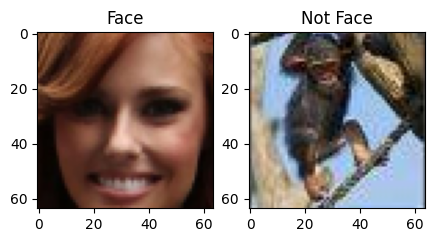

In [29]:
### Examining the CelebA training dataset ###

# @title Change the sliders to look at positive and negative training examples@ { run: "auto"}

face_images = images[np.where(labels == 1)[0]].transpose(0, 2, 3, 1)
not_face_images = images[np.where(labels == 0)[0]].transpose(0, 2, 3, 1)

idx_face = 23 # @param {type:"slider", min:0, max:50, step:1}
idx_not_face = 9 # @param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title('Face')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title('Not Face')
plt.grid(False)

Thiking about bias

Remember we'll be training our facial detection classifiers on the large, well-cureated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an indepedent test dataset. Our goal is to build a model that trains on CelebA and achieves high classification accuracy on the test dataset across all demographics, and to thus show that this model does not suffer from any hidden bias.

What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about latent variables, variables that define a dataset but are not strictly observed. As defined in the generative modeling lecture, we'll use the term latent space to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier biased if its classification decision changes after it sees some additional latent features. This notion of bias may be helpful to keep in mind throughout the rest of the lab.

2.2 CNN for Facial Detection

First, we'll define and train a CNN on the facil classification task, and evaluate its accuracy. Later, we'll evaluate the perfomance of our debiased models against this baseline CNN. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction.

Define and train the CNN Model

Like we did in the first part of the lab, we'll define our CNN Model, and then train on the CelebA and ImageNet datasets by leveraging PyTorch's automatic differentiation (torch.autograd) by using the loss.backward() and optimizer.step() functions.

In [30]:
### Define the CNN Model ###

n_filters = 12 # base number of convolutional filters
in_channels = images.shape[1]

def make_standard_classifier(n_outputs):
    """Create a standard CNN classifier."""

    # Start by first defining a convolutional block
    class ConvBlock(nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
            super().__init__()
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            self.relu = nn.ReLU(inplace=True)
            self.bn = nn.BatchNorm2d(out_channels)


        def forward(self, x):
            x = self.conv(x)
            x = self.relu(x)
            x = self.bn(x)
            
            return x
    
    # Now use the block to define the classifier
    model = nn.Sequential(
        ConvBlock(in_channels, n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(n_filters, 2*n_filters, kernel_size=5, stride=2, padding=2),
        ConvBlock(2*n_filters, 4*n_filters, kernel_size=3, stride=2, padding=1),
        ConvBlock(4*n_filters, 6*n_filters, kernel_size=3, stride=2, padding=1),
        nn.Flatten(),
        nn.Linear(H // 16 * W // 16 * 6 * n_filters, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, n_outputs),

    )

    return model.to(device)

# Call the function to instantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier)

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

Now let's train the standard CNN!

In [31]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if "experiment" in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment

In [32]:
### Train the standard CNN ###
loss_fn = nn.BCEWithLogitsLoss()
# Training hyperparameters
params = dict(
    batch_size = 32,
    num_epochs = 2,
    learning_rate = 5e-4,
)

In [33]:
experiment = create_experiment('Lab2_Part2_CNN', params)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/anthonny20/lab2-part2-cnn/6accb4125a7b427383c12d429c01808c

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]


In [34]:
# Defining our optimizer
optimizer = optim.Adam(
    standard_classifier.parameters(), lr=params['learning_rate']
)
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear() # clear if it exists

# set the model to train mode
standard_classifier.train() 

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

In [35]:
def standard_train_step(x, y):
    x = torch.from_numpy(x).float().to(device)
    y = torch.from_numpy(y).float().to(device)

    # clear the gradients
    optimizer.zero_grad()

    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = loss_fn(logits, y)

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss

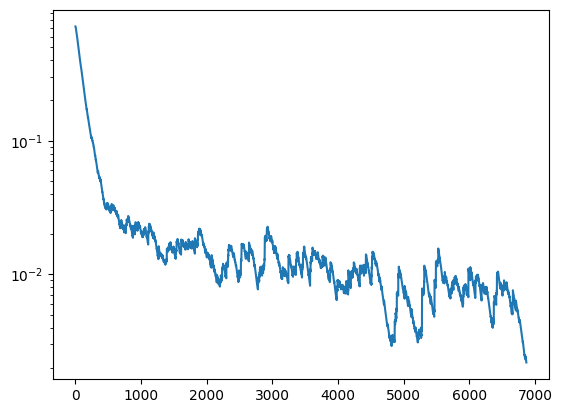

100%|██████████| 3434/3434 [02:56<00:00, 19.46it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : delicate_elbow_4606
COMET INFO:     url                   : https://www.comet.com/anthonny20/lab2-part2-cnn/6accb4125a7b427383c12d429c01808c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7555] : (2.7939660185438697e-07, 0.7131081819534302)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 2
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook       

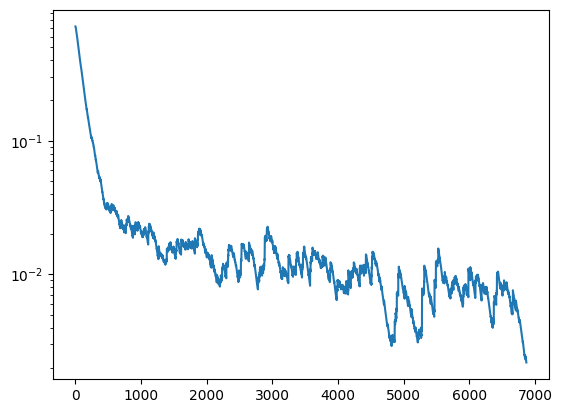

In [36]:
# The Training Loop
step = 0
for epoch in range(params["num_epochs"]):
    for idx in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(params["batch_size"])
        loss = standard_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()

        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        experiment.log_metric('loss', loss_value, step=step)
        step += 1
experiment.end()

Evaluate perfomance of the standard CNN

Next, let's evaluate the classification performance of our CelebA-trained standard CNN on the training dataset.

In [37]:
### Evaluation of standard CNN ###

# set the model to eval mode
standard_classifier.eval()

# TRAINING DATA
# Evaluate on a subset of CeleA+ImageNet
(batch_x, batch_y) = loader.get_batch(5000)
batch_x = torch.from_numpy(batch_x).float().to(device)
batch_y = torch.from_numpy(batch_y).float().to(device)

with torch.inference_mode():
    y_pred_logits = standard_classifier(batch_x)
    y_pred_standard = torch.round(torch.sigmoid(y_pred_logits))
    acc_standard = torch.mean((batch_y == y_pred_standard).float())

print(
    "Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(
        acc_standard.item()
    )
)


Standard CNN accuracy on (potentially biased) training set: 0.9984


We'll also evaluate our networks on an independent test dataset containing faces that were not seen during training. For the test data, we'll look at the classification accuracy four different demographics, based on the Flitzpatrick skin scale and sex-based labels: dark-skinned male, darr-skinned female, light-skinned male, light-skinned female.

Let's take a look at some sample faces in the test set.

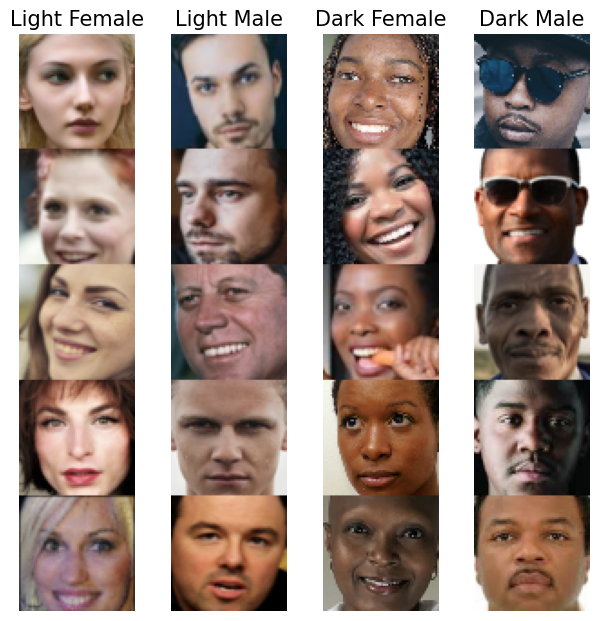

In [38]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces(channels_last=channels_last)
keys = ['Light Female', 'Light Male', 'Dark Female', 'Dark Male']

fig, axs = plt.subplots(1, len(keys), figsize=(7.5, 7.5))
for i, (group, key) in enumerate(zip(test_faces, keys)):
    axs[i].imshow(np.hstack(group).transpose(1, 2, 0))
    axs[i].set_title(key, fontsize=15)
    axs[i].axis("off")

Now, let's evaluate the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just trained.

array([0.62540305, 0.7968542 , 0.71231264, 0.70630044], dtype=float32)

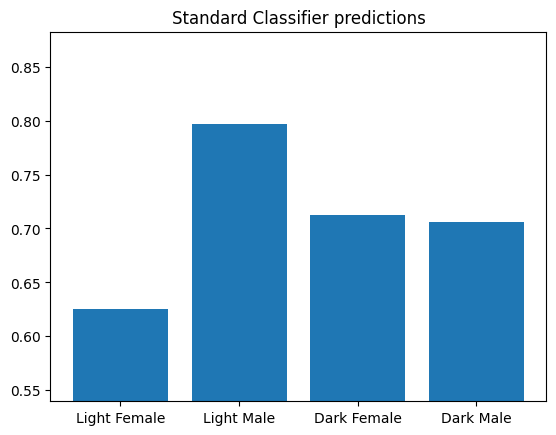

In [39]:
### Evaluate the standard CNN on the test data ###

standard_classifier_probs_list = [] # Store each demographic's probabilities

with torch.inference_mode():
    for x in test_faces:
        x = torch.from_numpy(np.array(x, dtype=np.float32)).to(device)
        logits = standard_classifier(x)  # [B, 1]
        probs = torch.sigmoid(logits)    # [B, 1]
        probs = torch.squeeze(probs, dim=-1) # shape [B]
        standard_classifier_probs_list.append(probs.cpu().numpy())

standard_classifier_probs = np.stack(standard_classifier_probs_list, axis=0)

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.mean(axis=1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() -np.ptp(yy) / 2.0), yy.max() + np.ptp(yy) / 2.0)
plt.title("Standard Classifier predictions")
yy


Take a look at the accuracies for this first model across these four groups. What do you observe? Would ou considerthis model biased or unbiased? What are some reasons why a trained model may have biased accuracies ?

2.3 Mitigating algorithmic bias

Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in CelebA (our training set) are those of light-skinned females. As a result, a classifier trained on CelebA will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased.

How could we overcome this? A naive solution --  and one that is being adopted by many companies and organizations -- would be to annotate different subclasses (i.e., light-skinned females, males with hates, etc.) within the training data, and then manually even out the data with respect to those groups.

But this approach has two major disadvantages. First, it requires annotating massive amounts of data, which is not scalable. Second, it requires that we know what potential biases (e.g. race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the different features that are imbalanced within the training data.

Instead, let's actually learn these feature in an unbiased, unsupervised manner, without the need for any annotation, and then train a classifier fairly with respect to these features. In the rest of this lab, we'll do exactly that.

2.4 Variational Autoencoder (VAE) for learning latent structure

- As you saw, the accuracy of the CNN varies across the four demographics we looked at. To think about this may be, consider the dataset the model was trained on, CelebA. If certain features, such as dark skin or hats, are rare in CelebA, the model may end up biased against these as result of training with a biased dataset. That is to say, its classification accuracy will be worse on faces that have under-represented features, such as dark-skinned faces or faces with hats, relative to faces with features well-represented in the training data! This is a problem.
 - Our goal is to train a debiased version of this classifier -- one that that accounts for potential disparities in feature representation within the training data. Specifically, to build a debiased facial classifier, we'll train a model that learns a representation of the underlying latent space to the face training data. The model the uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, more frequently during training. The key design requirement for our model is that can learn an encoding of the latent features in the face data in an entirely unsupervised way. To achieve this, we'll turn to variatonal autoencoders (VAEs).
 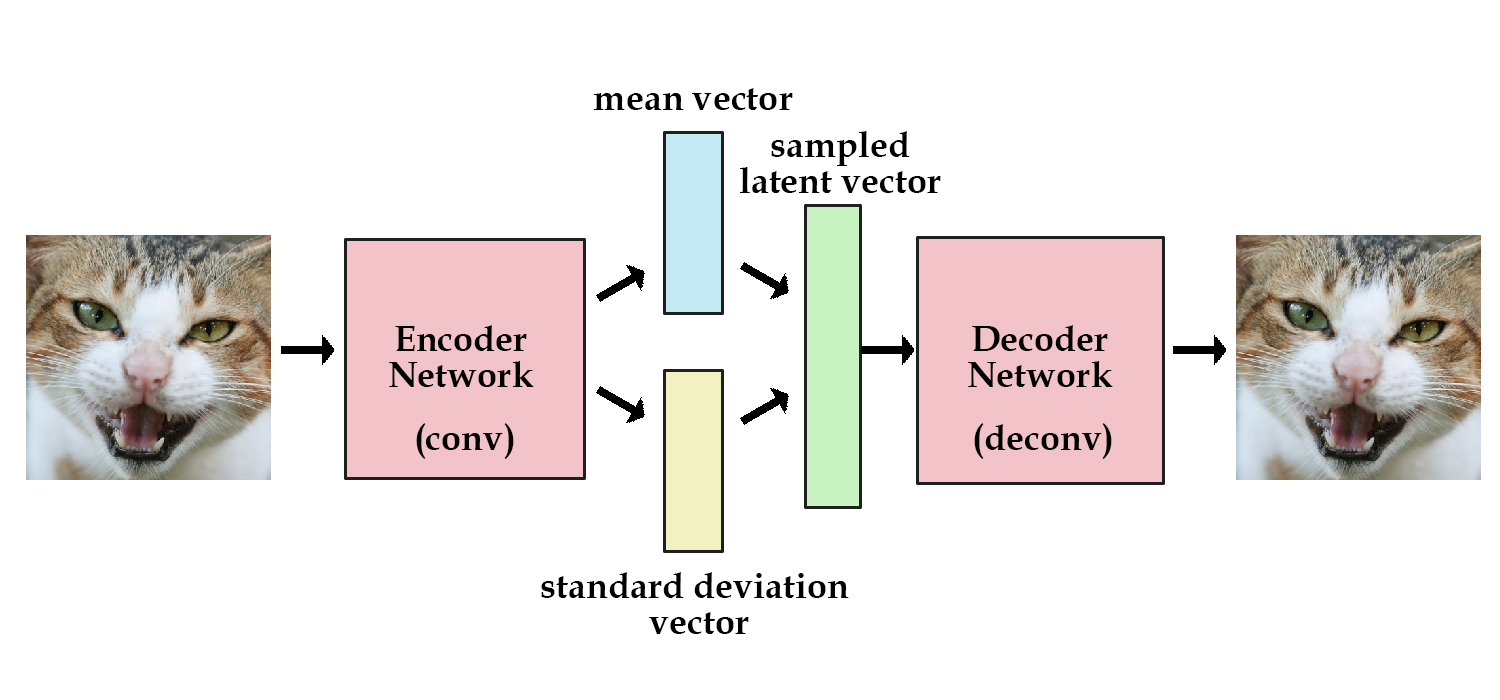

As shown in the schematic above and in Lecture 4, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn.

Let's formalize two key aspects of the VAE model and define relevant functions for each.

Understanding VAEs: loss function

- In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned paremeters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss.
- What this means is that we'll have two terms in our VAE loss function:
    - Latent Loss (L-KL): measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
    - Reconstruction loss (LX(X, X^)): measures how accurately the reconstructed outputs match the input and is given by the L¹ norm of the input image and its reconstructed output.
- The equation for the latent loss is provided by: 
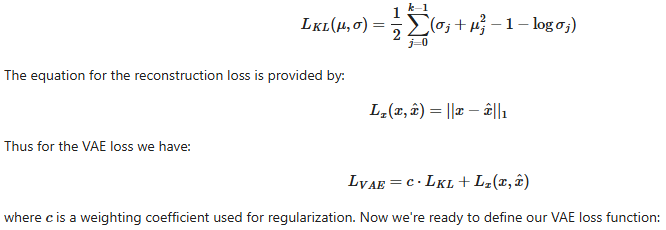

In [40]:
### Defining the VAE loss function ###
'''Function to calculate VAE loss given:
    an input x,
    reconstructed output x_recon,
    encoded means mu,
    encoded log of standard deviation logsigma,
    wieght parameter for the latent loss kl_weight
'''

def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
    # in the text block directly above
    latent_loss = 0.5 * torch.sum(torch.exp(logsigma) + torch.pow(mu) - 1 - logsigma, dim = 1)

    # TODO: Define the reconstruction loss as the mean absolute pixel-wise
    # difference between the input and reconstruction. Hint: you'll need to
    # use torch.mean, and specify the dimensions to reduce over.
    # For example, reconstruction loss needs to average
    # over the height, width, and channel image dimensions.
    reconstruction_loss = torch.mean(torch.abs(x - x_recon), dim=(1, 2, 3))

    # TODO: Define the VAE loss: Note this is given in the equation for L_{VAE}
    # in the text block directly above
    vae_loss = kl_weight * latent_loss + reconstruction_loss

    return vae_loss

- Great! Now that we have a more concrete sense of how VAEs work, let's explore how we can leverage this network structure to train a debiased facial classifier.

Understanding VAEs: reparameterization

- As you may recall from lecture, VAEs use a "reparameterizaion trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. Formalizing this for a latent variable z where we sample e ~ N(0,(I)) we have:
        -   z = u + e^(1/2.logE) . e
where u is the mean and E is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, and make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

Let's define a function to implement the VAE sampling operation:

In [41]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
   z_mean, z_logsimga(tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""

def sampling(z_mean, z_logsigma):
    # Generate random noise with the same shape as z_mean, sampled from a standard normal distribution (mean=0, std=1)
    eps = torch.randn_like(z_mean)

    # # TODO: Define the reparameterization computation!
    # # Note the equation is given in the text block immediately above.
    z = z_mean + z_logsigma * eps
    return z

2.5 Debiasing Variational Autoencoder (DB-VAE)

- Now, we'll use the general idea behind the VAE architecture to build a model, termed a debiasing variational autoencoder or DB-VAE, to mitigate (potentially) unknown biases preset within the training idea. We'll train our DB-VAE model on the facial detection task, run the debiasing operation during training, evaluate on the PPB dataset, and compare its accuracy to our original, biased CNN model.

The DB_VAE Model

- The key idea behind this debiasing approach is to use the latent variables learned via a vae adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hates) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data).
A general schematic of the DB-VAE approach is shown here:
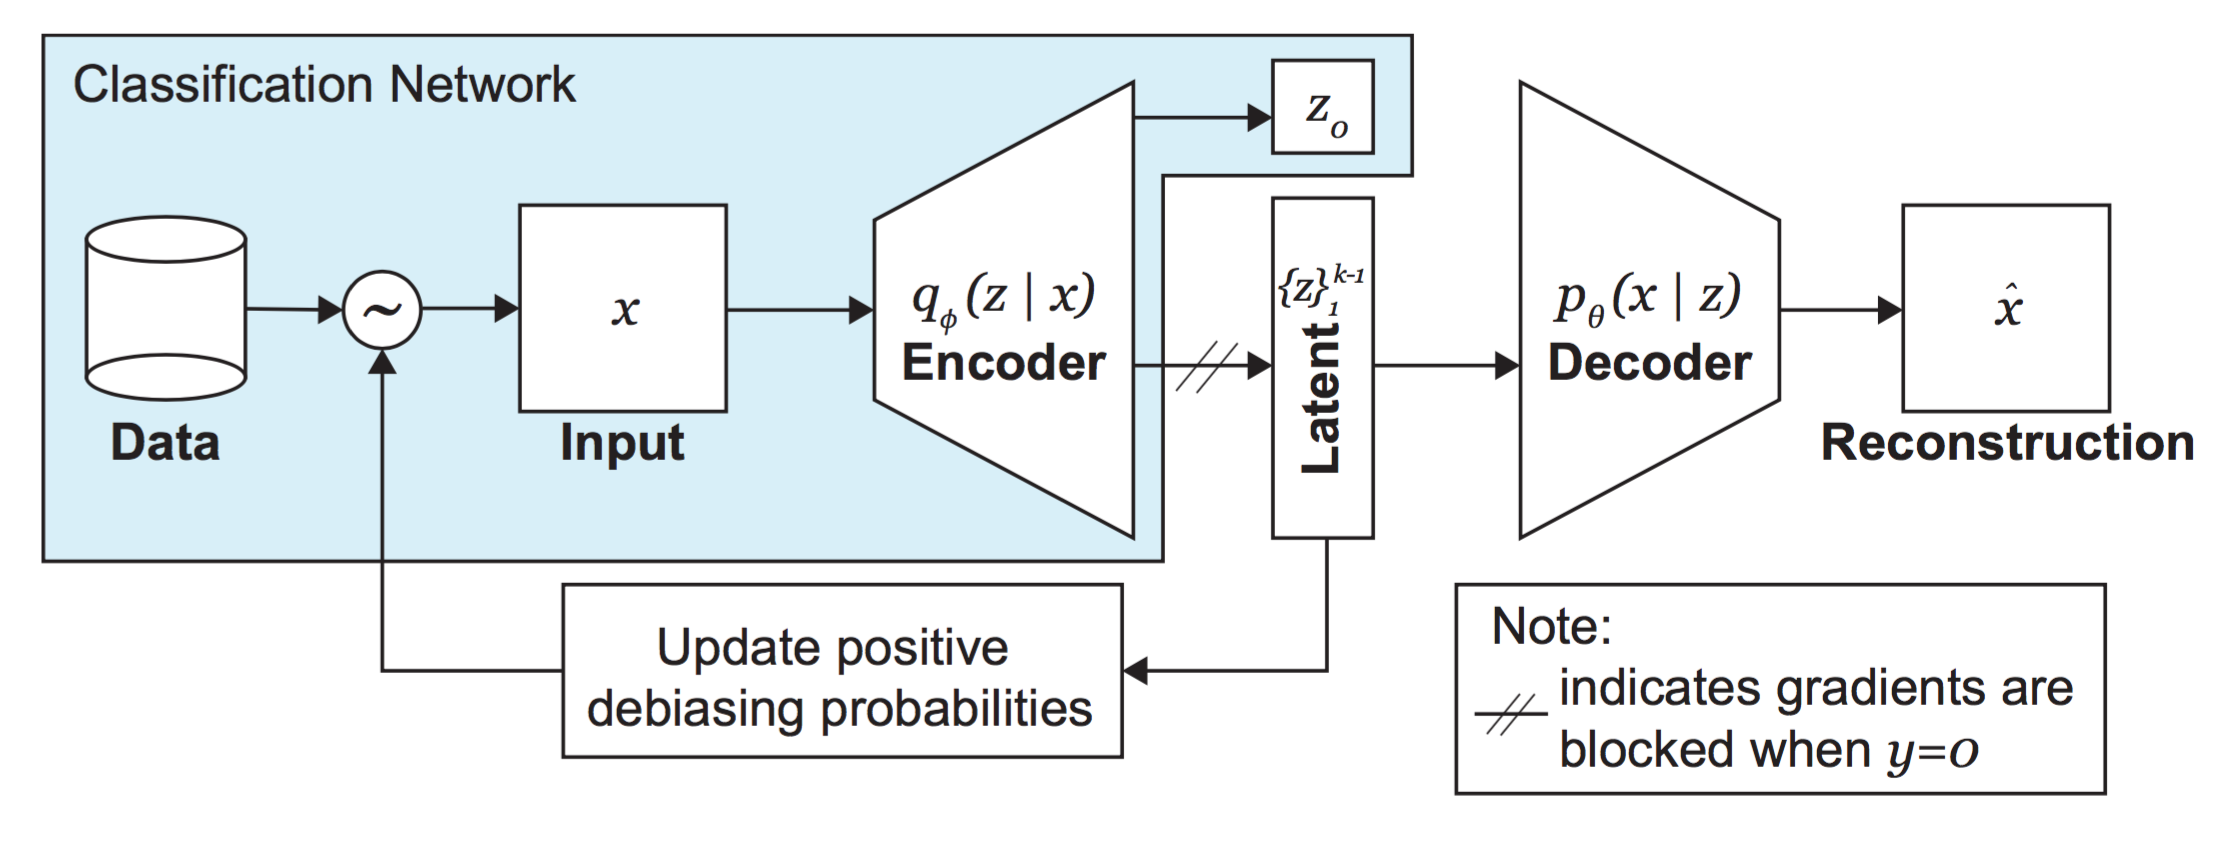
- Recall that we want to apply our DB-VAE to a supervised classification problem --  the facial detection task. Importantly, note how the encoder portion in the DB-VAE architecture also outputs a single supervised variable, z0, corresponding to the class prediction -- face or not face.
Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is another key distinction between the DB-VAE and a traditional VAE.
- Keep in mind that we only want to learn the latent representation of faces, as that's what we're ultimately debiasing against, even though we are training a model on a binary classification problem. We'll need to ensure that, for faces, our DB-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution q(z|x), and outputs a supervised class prediction z0, but that, for negative examples, it only outputs a class prediction z0.

Defining the DB-VAE loss function

- This means we'll need to be a bit clever about the loss function for the DB-VAE. The form of the loss will depend on whether it's face image or non-face image that's being considered.

- For face images, our loss funtion will have two components:
    1. VAE loss (LV AE): consists of the latent loss and the reconstruction loss.
    2. Classification loss (Ly(y, y^)): standard cross-entropy loss for a binary classification problem.

- In contrast, for images of non-faces, our loss function is solely the classification loss.

- We can write a single expression for the loss by defining an indicator variable 'If' which reflects which training data are images of faces(If(y) = 1) and which are images of non-faces(If(y) = 0). Using this, we obtain:
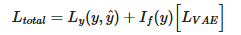

Let's write a function to define the DB-VAE loss function:

In [42]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    # TODO: call the relevant function to obtain VAE loss
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)

    # TODO: define the classification loss using binary_cross_entropy
    classification_loss = F.binary_cross_entropy_with_logits(
        y_logit, y, reduction="none"
    )
    
    # Use the training data labels to create variable face_indicator:
    #   indicator that reflects which training data are images of faces
    y = y.float()
    face_indicator = (y == 1.0).float()

    # TODO: define the DB-VAE total loss! Use torch.mean to average over all samples
    total_loss = torch.mean(classification_loss * face_indicator + vae_loss)
    
    return total_loss, classification_loss

DB-VAE Architecture

- Now we're ready to define the DB-VAE architecture. To build the DB-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initializae the two models, and then construct the end-to-end VAE. We will use a latent space with 100 latent variables.
- The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [43]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network(latent_dim=100, n_filters=12):
    """
    Function builds a face-decoder network.

    Args:
        latent_dim (int): the dinmension of the latent representation
        n_filters (int): base number of convolutional filters

    Returns:
        decoder_model (nn.Module): the decoder network
    """
    class FaceDecoder(nn.Module):
        def __init__(self, latent_dim, n_filters):
            super(FaceDecoder, self).__init__()

            self.latent_dim = latent_dim
            self.n_filters = n_filters

            # Linear (fully connected) layer to project from latent space
            # to a 4 x 4 feature map with (6*n_filters) channels
            self.linear = nn.Sequential(
                nn.Linear(latent_dim, 4 * 4 * 6 * n_filters),
                nn.ReLU()
            )

            # Convolutional upsampling (inverse of an encoder)
            self.deconv = nn.Sequential(
                # [B, 6n_filters, 4, 4] -> [B, 4n_filters, 8, 8]
                nn.ConvTranspose2d(
                    in_channels=6 * n_filters,
                    out_channels=4 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 2n_filters, 16, 16] -> [B, n_filters, 32, 32]
                nn.ConvTranspose2d(
                    in_channels=2 * n_filters,
                    out_channels=n_filters,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
            )
        
        def forward(self, z):
            """
            Forward pass of the decoder.

            Args:
                z (Tensor): Latent codes of shape [batch_size, latent_dim].

            Returns:
                Tensor of shape [batch_size, 3, 64, 64], representing
                the reconstructed images.
            """
            x = self.linear(z) # [B, 4*4*6*n_filters]
            x = x.view(-1, 6 * self.n_filters, 4, 4) # [B, 6n_filters, 4, 4]

            # Upsample through transposed convolutions
            x = self.deconv(x) # [B, 3, 64, 64]
            return x
    
    return FaceDecoder(latent_dim, n_filters)